**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

## Load the dataset

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



**<center>Data Dictionary</center>**


| Variable	| Definition	| Key |
|-----------|---------------|-----|
|survival	| Survival	| 0 = No, 1 = Yes |
|pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
|sex	| Sex	| |
|Age	| Age in years	| |
|sibsp	| # of siblings / spouses aboard the Titanic	| |
|parch	| # of parents / children aboard the Titanic	| |
|ticket	|Ticket number	| |
|fare	| Passenger fare	| |
|cabin	| Cabin number	| |
|embarked	| Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton | |

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
for i in train[list(train)]:
    if train[i].isna().sum() / len(train) > 0:
        print('missing value in {} is {:,.2f} %'.format(i, (train[i].isna().sum() / len(train))*100))
    

missing value in Age is 19.87 %
missing value in Cabin is 77.10 %
missing value in Embarked is 0.22 %


In [6]:
train = train.dropna(subset=['Embarked'])

In [7]:
# as the PassengerId is just ID we can get rid of this column in train
# drop Cabin column as well because we have 77% of missing data
train = train.drop(columns=['PassengerId','Cabin'], axis=1)
test = test.drop(columns=['PassengerId','Cabin'], axis=1)


In [8]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,712.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681
std,0.486260,0.834700,14.492933,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We have:

1) 38% of survivors;

2) 75% of passengers younger than 38;

3) 75% of passengers with fare less than 31.



## Feature Analysis

In [9]:
#make a funktion to describe all the needed information
def analysis(df,feature):
    sns.countplot(x=feature, hue='Survived', data = train)
    return plt.show(), print('% of survivors in'.format(feature), train.groupby(by=feature).mean()['Survived'].sort_values(ascending=False))

### Pclass

Check how many survivors we have in each class

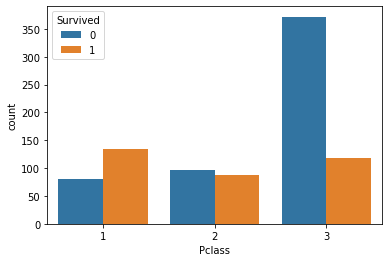

% of survivors in Pclass
1    0.626168
2    0.472826
3    0.242363
Name: Survived, dtype: float64


(None, None)

In [10]:
analysis(train,'Pclass')

The higher percent of survivors is in the 1st Class. Nothing unpredictable.

Check how is Class correlated with embarkation port.

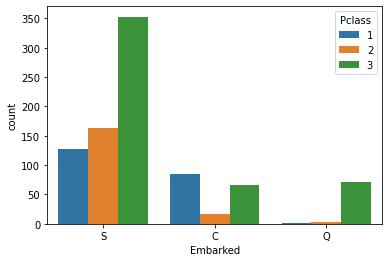

In [11]:
sns.countplot(x='Embarked', hue='Pclass', data = train);

We see that most of the people from 3rd class embarked in Queenstown and Southampton. It could affect the survival %.

Check the age distribution.

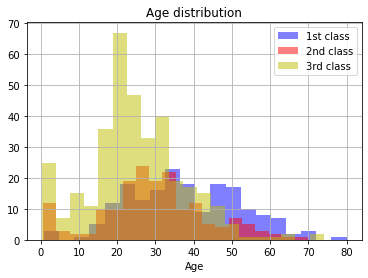

In [12]:
plt.hist(train[train.Pclass==1]['Age'],color='b',alpha=0.5, label='1st class', bins=20)
plt.hist(train[train.Pclass==2]['Age'],color='r',alpha=0.5, label='2nd class',bins=20)
plt.hist(train[train.Pclass==3]['Age'],color='y',alpha=0.5, label='3rd class',bins=20)
plt.title('Age distribution')
plt.xlabel('Age')
plt.grid(True)
plt.legend();

Check the fare distribution.

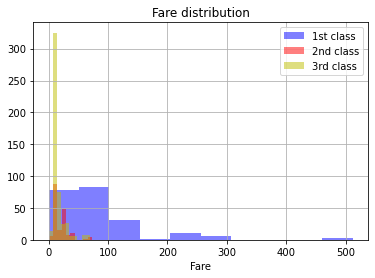

In [13]:
plt.hist(train[train.Pclass==1]['Fare'],color='b',alpha=0.5, label='1st class')
plt.hist(train[train.Pclass==2]['Fare'],color='r',alpha=0.5, label='2nd class')
plt.hist(train[train.Pclass==3]['Fare'],color='y',alpha=0.5, label='3rd class')
plt.title('Fare distribution')
plt.xlabel('Fare')
plt.grid(True)
plt.legend();

People from 1st class are older. As we see from `fare` histogram, they are reacher and can afford tickets with higher class.

### Name

In [14]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

We can take the title out of the people names in order to make a separate feature.

In [15]:
train['Title'] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
train['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Lady              1
Don               1
Sir               1
Ms                1
the Countess      1
Capt              1
Jonkheer          1
Mme               1
Name: Title, dtype: int64

In [16]:
test['Title'] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [17]:
#the column Name is no longer needed as surely there is no correlation between survival and passenger names
train = train.drop(columns='Name', axis=1)
test = test.drop(columns='Name', axis=1)

Check the relation between `Title` and survival.

In [18]:
train.groupby(by='Title').sum()['Survived'].sort_values(ascending=False)

Title
Miss            126
Mrs              98
Mr               81
Master           23
Dr                3
Mlle              2
Sir               1
Ms                1
Mme               1
the Countess      1
Col               1
Major             1
Lady              1
Jonkheer          0
Rev               0
Don               0
Capt              0
Name: Survived, dtype: int64

Miss, Mrs and Mr have higher survival rate.

Check the age of people with unique Title. It could be useful later in order to fill in N/A values in `Age`.

In [19]:
train.groupby(by='Title').mean()['Age'].sort_values(ascending=False)

Title
Capt            70.000000
Col             58.000000
Sir             49.000000
Major           48.500000
Lady            48.000000
Rev             43.166667
Dr              42.000000
Don             40.000000
Jonkheer        38.000000
Mrs             35.654206
the Countess    33.000000
Mr              32.368090
Ms              28.000000
Mme             24.000000
Mlle            24.000000
Miss            21.662069
Master           4.574167
Name: Age, dtype: float64

### Sex

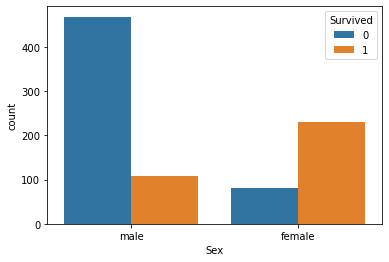

% of survivors in Sex
female    0.740385
male      0.188908
Name: Survived, dtype: float64


(None, None)

In [20]:
analysis(train,'Sex')

Higher % of female has survived.

Transform `Sex` into 0 and 1.

In [21]:
train['Sex'] = train['Sex'].astype('category')
train['Sex'] = train['Sex'].cat.codes

In [22]:
test['Sex'] = test['Sex'].astype('category')
test['Sex'] = test['Sex'].cat.codes

### Age

Check the distribution of age and let's try to find the way to fill in missing values.

In [23]:
train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
28.00    25
19.00    25
         ..
55.50     1
74.00     1
0.92      1
70.50     1
12.00     1
Name: Age, Length: 88, dtype: int64

Check the number of missing values with relation of Title.

In [24]:
train[train['Age'].isna()]['Title'].value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64

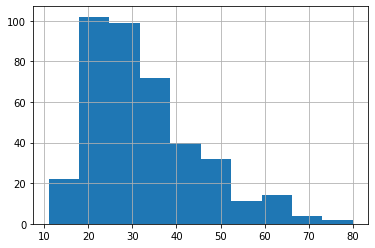

In [25]:
train[train['Title'] == 'Mr']['Age'].hist();

We can assume that `Age` is higly correlated with `Title`. Let's fill in the missing values with mean value for each `Title`.

In [26]:
train[train['Age'].isna()]['Title'].value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64

In [27]:
train['Age'] = train['Age'].fillna(train.groupby(['Pclass','Title',])['Age'].transform('median'))

Let's check the histogram for age distribution among passengers that have survived and passengers who haven't survived.

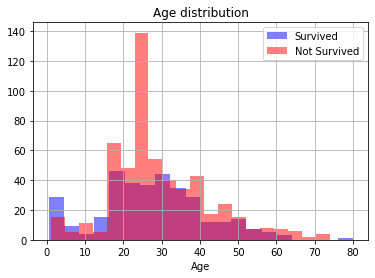

In [28]:
plt.hist(train[train.Survived==1]['Age'],color='b',alpha=0.5, label='Survived', bins=20)
plt.hist(train[train.Survived==0]['Age'],color='r',alpha=0.5, label='Not Survived',bins=20)
plt.title('Age distribution')
plt.xlabel('Age')
plt.grid(True)
plt.legend();

We see that childs have priority in survival.The high value in age of 32 comes from the replacement of missing values with mean for each `Title`, we had a lot of missing age in Title `Mr`.

### SibSp & Parch

Join 2 columns and make a column `family_size`.

In [29]:
train['family_size'] = train['SibSp'] + train['Parch']
#drop columns that are not usefull anymore
train.drop(columns=['SibSp','Parch'], inplace=True)

In [30]:
test['family_size'] = test['SibSp'] + test['Parch']
#drop columns that are not usefull anymore
test.drop(columns=['SibSp','Parch'], inplace=True)

Let's check all the distributions of `family_size` among other main features.

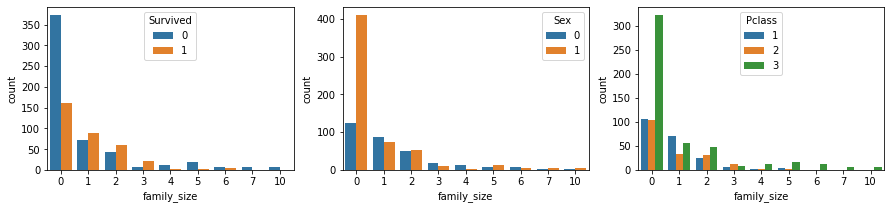

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,3))
sns.countplot(x='family_size', hue='Survived', data = train, ax=ax[0])
sns.countplot(x='family_size', hue='Sex', data = train, ax=ax[1])
sns.countplot(x='family_size', hue='Pclass', data = train, ax=ax[2]);

We can see that families with size 1-3 have higher % of survivors. Most probably that in there male/female quantities are almost equal. But it could also be affected with `Pclass`.

### Fare           

We have seen that `Fare` have some 0 values. Let's check it.

In [32]:
train[train['Fare'] == 0].head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Title,family_size
179,0,3,1,36.0,LINE,0.0,S,Mr,0
263,0,1,1,40.0,112059,0.0,S,Mr,0
271,1,3,1,25.0,LINE,0.0,S,Mr,0
277,0,2,1,31.0,239853,0.0,S,Mr,0
302,0,3,1,19.0,LINE,0.0,S,Mr,0


In [33]:
train[train['Fare'] == 0]['Fare'].value_counts()

0.0    15
Name: Fare, dtype: int64

In [34]:
train.groupby('Pclass')['Fare'].mean()

Pclass
1    84.193516
2    20.662183
3    13.675550
Name: Fare, dtype: float64

Let's replace these lines with mean value for each class.

In [35]:
train.loc[train['Fare'] == 0, 'Fare'] = \
    train.loc[train['Fare'] == 0, 'Pclass'].map(train.groupby('Pclass')['Fare'].mean())

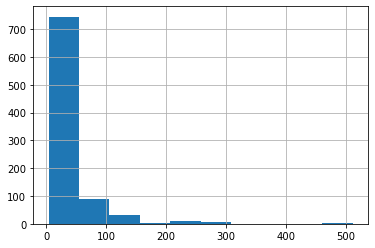

In [36]:
train['Fare'].hist();

In [37]:
#apply PowerTransofmer to make data more Gaussian-like
to_gauss = ['Fare']
scaler = PowerTransformer().fit(train[to_gauss])
train[to_gauss] = scaler.transform(train[to_gauss])
test[to_gauss] = scaler.transform(test[to_gauss])

Convert some columns to numerical and check the correlation between features.

In [38]:
train = pd.get_dummies(columns=['Embarked'], data=train, drop_first=True)
encoder = OrdinalEncoder()
cat_features = ['Title']
train[cat_features] = encoder.fit_transform(train[cat_features])

In [39]:
test = pd.get_dummies(columns=['Embarked'], data=test, drop_first=True)
encoder = OrdinalEncoder()
cat_features = ['Title']
test[cat_features] = encoder.fit_transform(test[cat_features])

interval columns not set, guessing: ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Title', 'family_size', 'Embarked_Q', 'Embarked_S']


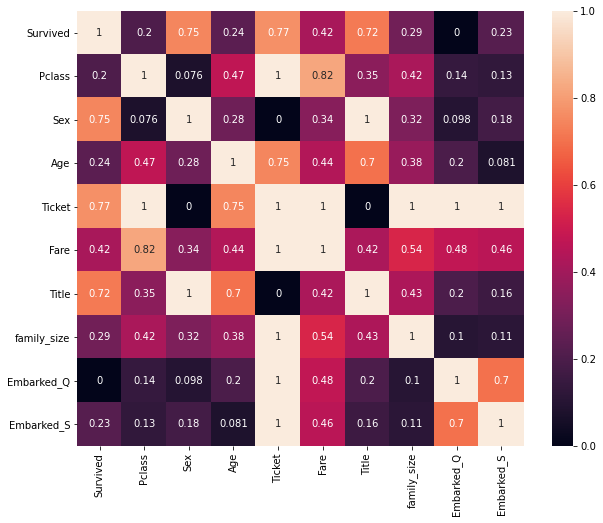

In [40]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(train.phik_matrix(), annot=True);

We can drop columns `Embarked_Q` as it is not correlated with target and `Ticket` as this column is highly correlated with other features.

In [41]:
train = train.drop(columns=['Embarked_Q','Ticket'], axis=1)
test = test.drop(columns=['Embarked_Q','Ticket'], axis=1)

## Prepairing data for models

Check the test data

In [42]:
test.head()

,Pclass,Sex,Age,Fare,Title,family_size,Embarked_S
0,3,1,34.5,-1.093298,5.0,0,0
1,3,0,47.0,-1.299217,6.0,1,1
2,2,1,62.0,-0.726218,5.0,0,0
3,3,1,27.0,-0.914947,5.0,0,1
4,3,0,22.0,-0.354106,6.0,2,1


In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    int8   
 2   Age          332 non-null    float64
 3   Fare         417 non-null    float64
 4   Title        418 non-null    float64
 5   family_size  418 non-null    int64  
 6   Embarked_S   418 non-null    uint8  
dtypes: float64(3), int64(2), int8(1), uint8(1)
memory usage: 17.3 KB


Fill the missing values in the test dataset.

In [44]:
test.loc[test['Age'].isna(), 'Age'] = \
    test.loc[test['Age'].isna(), 'Title'].map(test.groupby('Title')['Age'].mean())

In [45]:
test.loc[test['Fare'].isna(), 'Fare'] = \
    test.loc[test['Fare'].isna(), 'Pclass'].map(test.groupby('Pclass')['Fare'].mean())

In [46]:
test.isna().sum()

Pclass         0
Sex            0
Age            1
Fare           0
Title          0
family_size    0
Embarked_S     0
dtype: int64

In [47]:
test.loc[test['Age'].isna(), 'Age'] = \
    test.loc[test['Age'].isna(), 'Sex'].map(test.groupby('Sex')['Age'].mean())

In [48]:
test.isna().sum()

Pclass         0
Sex            0
Age            0
Fare           0
Title          0
family_size    0
Embarked_S     0
dtype: int64

Divide target and feature in train dataset

In [49]:
features = train.drop('Survived', axis=1)
target = train['Survived']

Let's make k-Fold cross-validator with 5 splits.

In [50]:
kf = KFold(n_splits=5, shuffle=True)

### Random Forest Classifier.

In [51]:
#make a list of parameters
parameters = {'max_depth': range (1, 10, 2), 'n_estimators': range (1, 100, 20)}
#load a model
model_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
grid = GridSearchCV(model_rf, parameters, scoring = 'roc_auc', cv=kf, n_jobs=-1)
grid.fit(features, target)
print('Best parameters:{}\nBest score:{}'.format(grid.best_params_, grid.best_score_))

Best parameters:{'max_depth': 5, 'n_estimators': 61}
Best score:0.8735184851068649


### LogisticRegression

In [52]:
#make a list of parameters
parameters = {'penalty': ['l1','l2']}
#load a model
model_lr = LogisticRegression(random_state=12345, class_weight='balanced', multi_class='ovr')
grid = GridSearchCV(model_lr, parameters, scoring = 'roc_auc', cv=kf, n_jobs=-1)
grid.fit(features, target)
print('Best parameters:{}\nBest score:{}'.format(grid.best_params_, grid.best_score_))

Best parameters:{'penalty': 'l2'}
Best score:0.8484688205884454


C:\Users\ilizak\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.84846882]
  warnings.warn(


### XGBClassifier

In [53]:
#make a list of parameters
parameters = {'n_estimators': [50, 100, 150, 200, 500], 'max_depth': [2, 4, 6, 8, 10]}
#load a model
model = XGBClassifier()
grid = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=kf, verbose=1)
grid.fit(features, target)
print('Best parameters:{}\nBest score:{}'.format(grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters:{'max_depth': 2, 'n_estimators': 100}
Best score:0.8679339133889886


Best result is shown by XGBClassifier.Let's calibrate the model with best parameters.

In [54]:
model = XGBClassifier(max_depth=2, n_estimators = 100, random_state=12345)
model.fit(features, target)
calibrated = CalibratedClassifierCV(model, method="sigmoid", cv=8)
calibrated.fit(features, target)
calibrated.score(features,target)

0.8875140607424072

Check which features are the most important for our model.

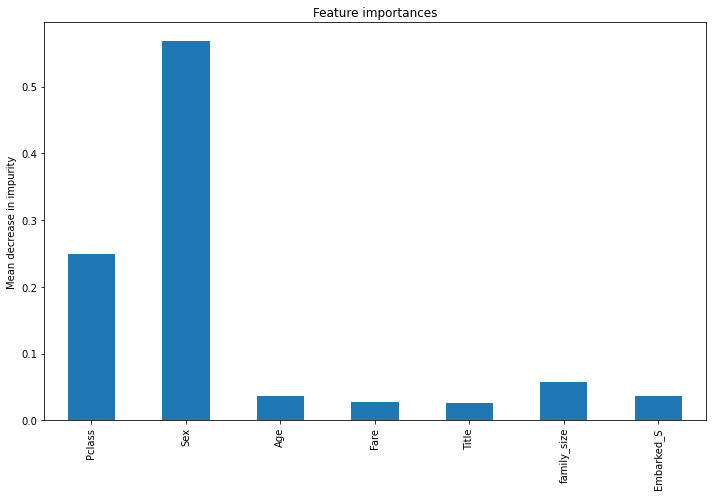

In [55]:
feature_names = features.columns
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The model used mostly all of the features that have been expected by us to be important. 

## Export the prediction dataset

In [56]:
prediction = calibrated.predict(test)

In [59]:
ids = pd.read_csv('test.csv')[['PassengerId']].values
df = {'PassengerId': ids.ravel(), 'Survived':prediction}
submission = pd.DataFrame(df)
display(submission.head())
submission.to_csv('submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
